#Pyspark ETL Process

##Installations

In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [805 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,690 kB]
Get:13 http://archive.ubuntu.com/ubuntu

In [2]:
import os
import sys

import findspark
findspark.init()
findspark.find()


'/usr/local/lib/python3.10/dist-packages/pyspark'

##Imports

In [3]:
from pyspark.sql import SparkSession

In [4]:
from pyspark.sql.functions import col, explode, year, sum, countDistinct, desc
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

##Create SparkSession

In [6]:
spark = SparkSession.builder.appName('PysparkETLyoutube').getOrCreate()

##Read Datasets

Read the *BR_youtube_trending_data.csv* dataset into a Dataframe

In [7]:
BR_youtube_trending_data_schema = StructType(fields=[StructField('video_id', StringType(), False),
                                                     StructField('title', StringType(), True),
                                                     StructField('publishedAt', DateType(), True),
                                                     StructField('channelId', StringType(), True),
                                                     StructField('channelTitle', StringType(), True),
                                                     StructField('categoryId', StringType(), True),
                                                     StructField('trending_date', DateType(), True),
                                                     StructField('tags', StringType(), True),
                                                     StructField('view_count', IntegerType(), True),
                                                     StructField('likes', IntegerType(), True),
                                                     StructField('dislikes', IntegerType(), True),
                                                     StructField('comment_count', IntegerType(), True),
                                                     StructField('thumbnail_link', StringType(), True),
                                                     StructField('comments_disabled', StringType(), True),
                                                     StructField('ratings_disabled', StringType(), True),
                                                     StructField('description', StringType(), True)
])

In [8]:
BR_youtube_trending_data_df = spark.read \
.schema(BR_youtube_trending_data_schema) \
.option('header', True) \
.csv('BR_youtube_trending_data.csv') \
.cache()

In [9]:
BR_youtube_trending_data_df.show(2)

+-----------+--------------------+-----------+--------------------+-----------------+----------+-------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|   video_id|               title|publishedAt|           channelId|     channelTitle|categoryId|trending_date|                tags|view_count| likes|dislikes|comment_count|      thumbnail_link|comments_disabled|ratings_disabled|         description|
+-----------+--------------------+-----------+--------------------+-----------------+----------+-------------+--------------------+----------+------+--------+-------------+--------------------+-----------------+----------------+--------------------+
|s9FH4rDMvds|LEVEI UM FORA? FI...| 2020-08-11|UCGfBwrCoi9ZJjKiU...|    Pietro Guedes|        22|   2020-08-12|pietro|guedes|ing...|    263835| 85095|     487|         4500|https://i.ytimg.c...|            False|           False|Salve rapaziada, ...|


In [10]:
BR_youtube_trending_data_df.printSchema()

root
 |-- video_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publishedAt: date (nullable = true)
 |-- channelId: string (nullable = true)
 |-- channelTitle: string (nullable = true)
 |-- categoryId: string (nullable = true)
 |-- trending_date: date (nullable = true)
 |-- tags: string (nullable = true)
 |-- view_count: integer (nullable = true)
 |-- likes: integer (nullable = true)
 |-- dislikes: integer (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- thumbnail_link: string (nullable = true)
 |-- comments_disabled: string (nullable = true)
 |-- ratings_disabled: string (nullable = true)
 |-- description: string (nullable = true)



In [11]:
BR_youtube_trending_data_df.count()

320085

Read the *BR_category_id.json* into a Dataframe

In [12]:
BR_category_id_df = spark.read \
.option('multiline', True) \
.json('BR_category_id.json')

In [13]:
BR_category_id_df.printSchema()

root
 |-- etag: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- etag: string (nullable = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- kind: string (nullable = true)
 |    |    |-- snippet: struct (nullable = true)
 |    |    |    |-- assignable: boolean (nullable = true)
 |    |    |    |-- channelId: string (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |-- kind: string (nullable = true)



In [14]:
BR_category_id_allfields_df = BR_category_id_df.select(col('kind').alias('kind_first'), col('etag').alias('etag_first'), explode(col('items')).alias('items')) \
.select('kind_first', 'etag_first', 'items.*') \
.select('kind_first', 'etag_first', 'etag', 'id', 'kind', 'snippet.*')

In [15]:
BR_category_id_allfields_df.show(2)

+--------------------+--------------------+--------------------+---+--------------------+----------+--------------------+----------------+
|          kind_first|          etag_first|                etag| id|                kind|assignable|           channelId|           title|
+--------------------+--------------------+--------------------+---+--------------------+----------+--------------------+----------------+
|youtube#videoCate...|kBCr3I9kLHHU79W4I...|IfWa37JGcqZs-jZeA...|  1|youtube#videoCate...|      true|UCBR8-60-B28hp2Bm...|Film & Animation|
|youtube#videoCate...|kBCr3I9kLHHU79W4I...|5XGylIs7zkjHh5940...|  2|youtube#videoCate...|      true|UCBR8-60-B28hp2Bm...|Autos & Vehicles|
+--------------------+--------------------+--------------------+---+--------------------+----------+--------------------+----------------+
only showing top 2 rows



In [16]:
final_category_id_df = BR_category_id_allfields_df.select('id', 'title')

In [17]:
final_category_id_df.show(2)

+---+----------------+
| id|           title|
+---+----------------+
|  1|Film & Animation|
|  2|Autos & Vehicles|
+---+----------------+
only showing top 2 rows



##Data Cleaning

In [18]:
BR_youtube_trending_data_cleaned_df = BR_youtube_trending_data_df.na.drop(thresh=13)

In [19]:
BR_youtube_trending_data_cleaned_df.count()

257390

##Select Specific Columns and Rename Them

In [20]:
BR_youtube_trending_data_selected_df = BR_youtube_trending_data_cleaned_df.select(col('video_id'), col('title'), col('publishedAt'), col('channelId'), col('channelTitle'),
                                                                                  col('trending_date'), col('view_count'), col('likes'), col('dislikes'), col('comment_count'),
                                                                                  col('comments_disabled'), col('ratings_disabled'), col('categoryId')) \
                                                                          .withColumnRenamed('title', 'video_title') \
                                                                          .withColumnRenamed('publishedAt', 'published_date') \
                                                                          .withColumnRenamed('channelId', 'channel_id') \
                                                                          .withColumnRenamed('channelTitle', 'channel_title') \
                                                                          .withColumnRenamed('categoryId', 'category_id') \
                                                                          .withColumn('publish_year', year(col('published_date')))

In [21]:
BR_youtube_trending_data_selected_df.show(2)

+-----------+--------------------+--------------+--------------------+-----------------+-------------+----------+------+--------+-------------+-----------------+----------------+-----------+------------+
|   video_id|         video_title|published_date|          channel_id|    channel_title|trending_date|view_count| likes|dislikes|comment_count|comments_disabled|ratings_disabled|category_id|publish_year|
+-----------+--------------------+--------------+--------------------+-----------------+-------------+----------+------+--------+-------------+-----------------+----------------+-----------+------------+
|s9FH4rDMvds|LEVEI UM FORA? FI...|    2020-08-11|UCGfBwrCoi9ZJjKiU...|    Pietro Guedes|   2020-08-12|    263835| 85095|     487|         4500|            False|           False|         22|        2020|
|jbGRowa5tIk|ITZY “Not Shy” M/...|    2020-08-11|UCaO6TYtlC8U5ttz6...|JYP Entertainment|   2020-08-12|   6000070|714310|   15176|        31040|            False|           False|      

##Join Dataframes on *category_id*

In [22]:
youtube_final_df = BR_youtube_trending_data_selected_df.join(final_category_id_df, BR_youtube_trending_data_selected_df.category_id == final_category_id_df.id, 'left') \
.select(col('video_id'), col('video_title'),  col('channel_id'), col('channel_title'), col('published_date'),
        col('trending_date'), col('view_count'), col('likes'), col('dislikes'), col('comment_count'),
        col('comments_disabled'), col('ratings_disabled'), col('category_id'), col('title'), col('publish_year')) \
.withColumnRenamed('title', 'category')

In [23]:
youtube_final_df.show(2)

+-----------+--------------------+--------------------+-----------------+--------------+-------------+----------+------+--------+-------------+-----------------+----------------+-----------+--------------+------------+
|   video_id|         video_title|          channel_id|    channel_title|published_date|trending_date|view_count| likes|dislikes|comment_count|comments_disabled|ratings_disabled|category_id|      category|publish_year|
+-----------+--------------------+--------------------+-----------------+--------------+-------------+----------+------+--------+-------------+-----------------+----------------+-----------+--------------+------------+
|s9FH4rDMvds|LEVEI UM FORA? FI...|UCGfBwrCoi9ZJjKiU...|    Pietro Guedes|    2020-08-11|   2020-08-12|    263835| 85095|     487|         4500|            False|           False|         22|People & Blogs|        2020|
|jbGRowa5tIk|ITZY “Not Shy” M/...|UCaO6TYtlC8U5ttz6...|JYP Entertainment|    2020-08-11|   2020-08-12|   6000070|714310|   1

##GroupBy and Aggregations

In [24]:
youtube_final_grouped_df = youtube_final_df\
.groupBy('category') \
.agg(sum('view_count').alias('total_view_count'), sum('likes').alias('total_likes'), sum('dislikes').alias('total_dislikes'),
     countDistinct('video_id').alias('number_of_video_id')) \
.orderBy(desc('total_view_count'))

In [25]:
youtube_output_df = youtube_final_grouped_df.fillna({'category':'Not specified'})

In [26]:
youtube_output_df.show()

+--------------------+----------------+-----------+--------------+------------------+
|            category|total_view_count|total_likes|total_dislikes|number_of_video_id|
+--------------------+----------------+-----------+--------------+------------------+
|               Music|    183513768694|11760799617|      99601624|              7548|
|       Entertainment|     92053312487| 5867127148|      41255107|              9278|
|              Gaming|     41120071831| 2277646981|      14402294|              5715|
|              Sports|     30187670261| 1344734776|       8264539|              6876|
|      People & Blogs|     24993319699| 2002087774|      22898820|              4446|
|              Comedy|      8419322245|  782885197|      10409764|              1417|
|Science & Technology|      8286633718|  262693293|       3738658|               496|
|    Film & Animation|      5830674820|  218843849|       1233210|               412|
|     News & Politics|      2893141479|   88032105|   

##Write the Output Dataframe into a Parquet File and Read it Back


In [27]:
youtube_output_df.write.mode('overwrite').parquet('youtube_output_df')

In [28]:
spark.read.parquet('youtube_output_df').show()

+--------------------+----------------+-----------+--------------+------------------+
|            category|total_view_count|total_likes|total_dislikes|number_of_video_id|
+--------------------+----------------+-----------+--------------+------------------+
|               Music|    183513768694|11760799617|      99601624|              7548|
|       Entertainment|     92053312487| 5867127148|      41255107|              9278|
|              Gaming|     41120071831| 2277646981|      14402294|              5715|
|              Sports|     30187670261| 1344734776|       8264539|              6876|
|      People & Blogs|     24993319699| 2002087774|      22898820|              4446|
|              Comedy|      8419322245|  782885197|      10409764|              1417|
|Science & Technology|      8286633718|  262693293|       3738658|               496|
|    Film & Animation|      5830674820|  218843849|       1233210|               412|
|     News & Politics|      2893141479|   88032105|   

##Data Visualization

In [29]:
x = [youtube_output_df.category for youtube_output_df in youtube_output_df.select('category').collect()]
y = [youtube_output_df.total_view_count for youtube_output_df in youtube_output_df.select('total_view_count').collect()]

Text(0.5, 1.0, 'Total views per category')

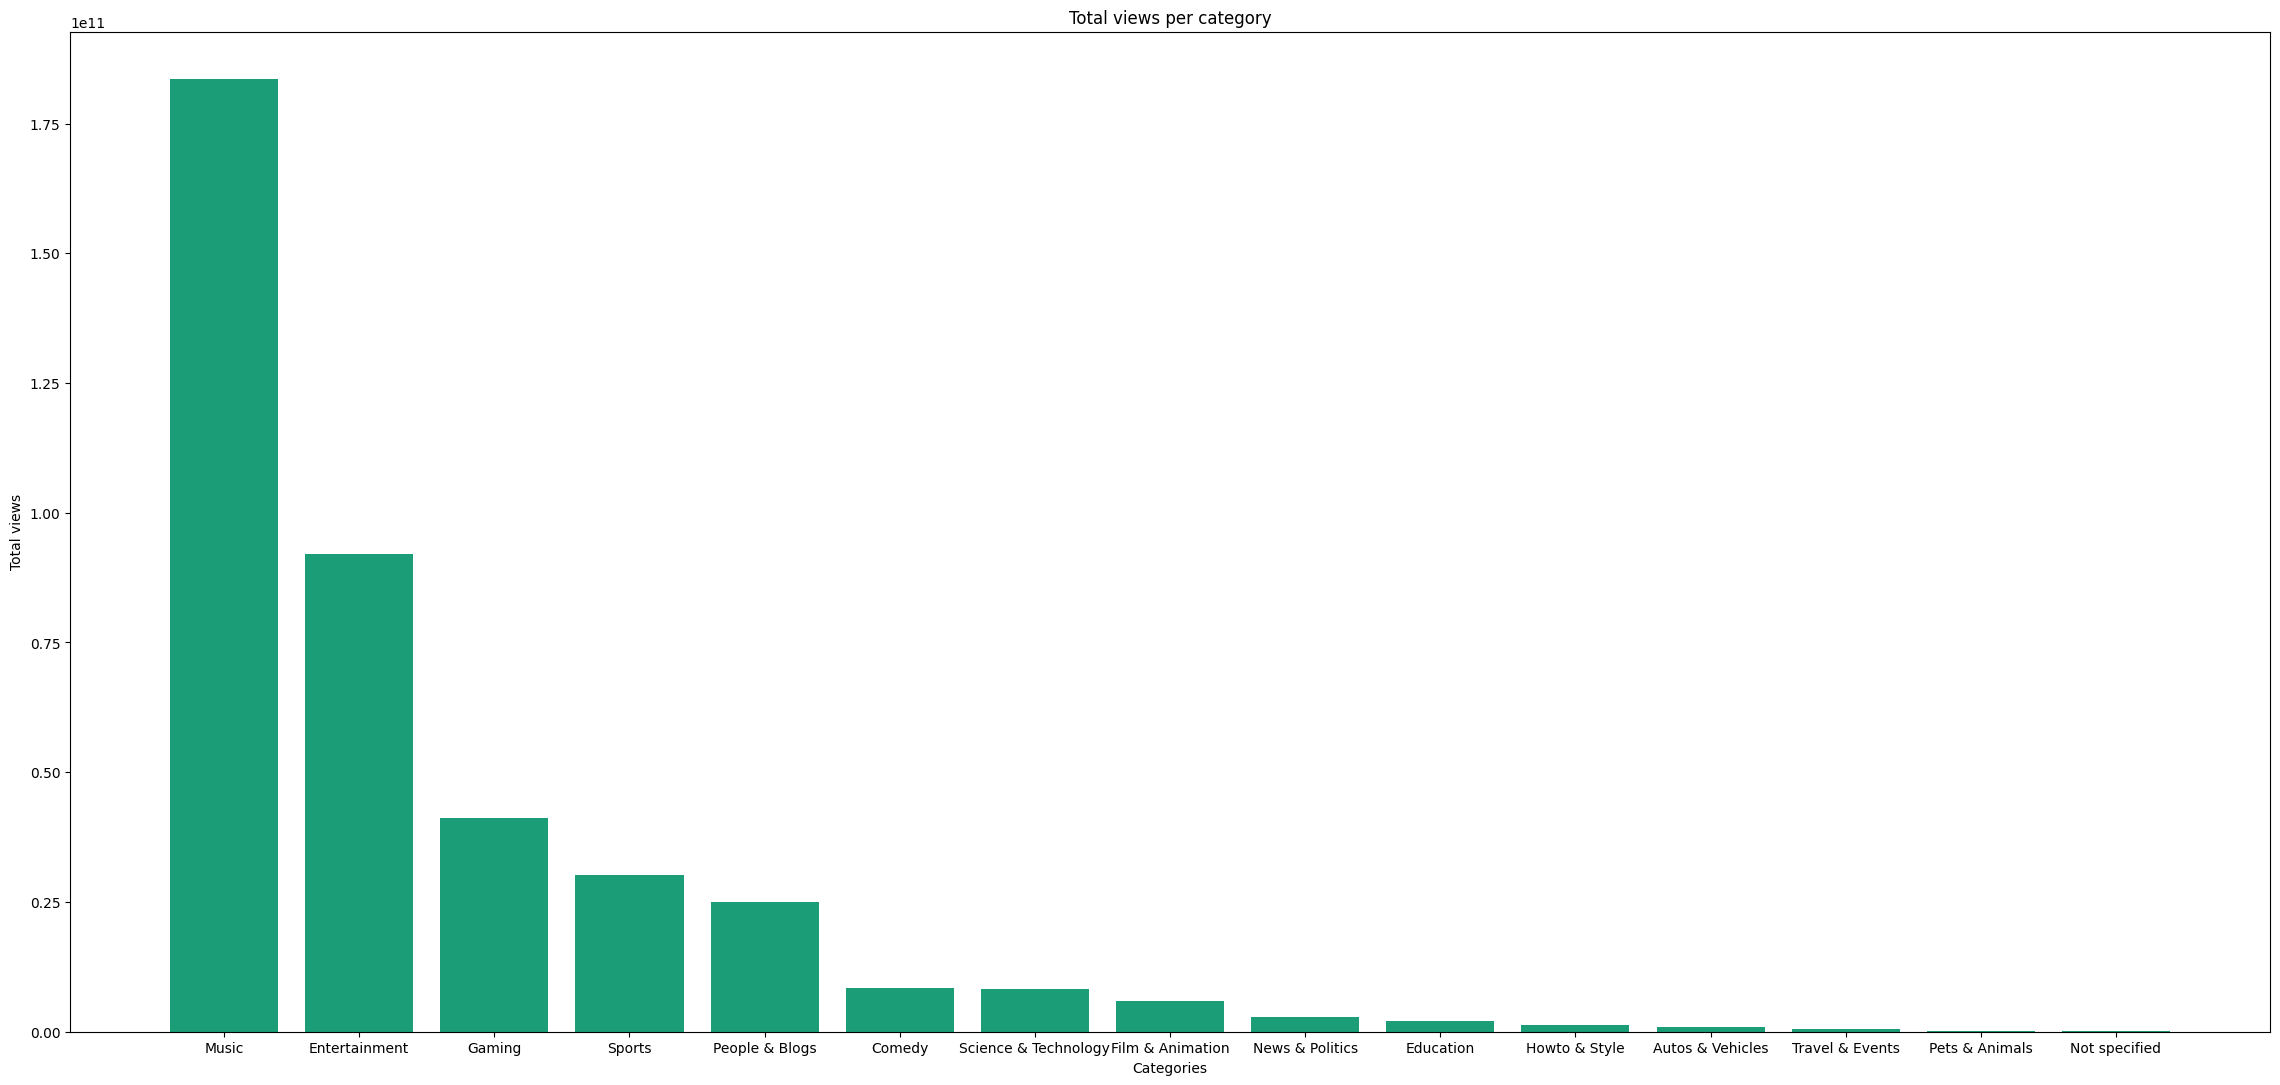

In [30]:
fig = plt.figure(figsize=(22,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y,color='#1b9e77')
ax.set_xlabel('Categories')
ax.set_ylabel('Total views')
ax.set_title('Total views per category')

##End the SparkSession
End the SparkSession in order for the JVMs to close and free the resourses.

In [31]:
spark.stop()